In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [12]:
colors = ['#116FA1', '#2DC0D2', '#E0B266', '#00979F', '#70CAC6', '#005A7D']
bg = '#F9F9F9'

In [39]:
##### Social Planner's Planning Problem #####

# I - Set parameters.

γ = 2.0  # coefficient of relative risk aversion
β = 0.95 # discount factor
δ = 0.02 # depreciation rate on capital
α = 0.33 # return to capital per capita
A = 1.0  # technology


# II - Define utility of HHs and technology of firms.

def u(c):
    """
    utility function
    """
    return (c ** (1 - γ) - 1) / (1 - γ) if γ != 1 else np.log(c)

def mu(c):
    """
    marginal utility w.r.t. consumption
    """
    return c ** (-γ)

def mu_inv(c):
    """ 
    Inverse of marginal utility
    """
    return c ** (-1 / γ)

def f(k):
    """
    output per-capita production function
    """
    return A * k ** α

def mpk(k):
    """ 
    marginal product w.r.t. per-capita capital
    """
    return α * A * k ** (α - 1)

def mpk_inv(k):
    """ 
    inverse of marginal product w.r.t. capital per-capita
    """
    return (k / (α * A)) ** (1 / (α - 1)) 

def next_k_and_c(k, c):
    """ 
    Given the current capital Kt and an arbitrary feasible consumption choice Ct,
    computes Kt+1 by state transition lwa and optimal Ct+1 by Euler equation.
    """
    k_next = f(k) + (1 - δ) * k - c # from law of motion
    c_next = mu_inv(mu(c) / (β * (1 + mpk(k_next) - δ)))
    return k_next, c_next


# III - Shooting algorithm

def shooting(c0, k0, T=10):
    """ 
    Given the initial condition of capital k0 and an initial guess of consumption c0,
    computes the whole paths of c an k using the state transition law and Euler equation for T periods.
    """
    assert c0 <= f(k0) + (1 - δ) * k0, 'Initial consumption is not feasible.'

    # Initialize vectors of c and k.
    c_vec = np.empty(T+1)
    k_vec = np.empty(T+2)

    c_vec[0] = c0
    k_vec[0] = k0

    for t in range(T):
        k_vec[t+1], c_vec[t+1] = next_k_and_c(k_vec[t], c_vec[t])

    k_vec[T+1] = f(k_vec[T]) + (1 - δ) * k_vec[T] - c_vec[T]

    return c_vec, k_vec

def bisection(c0, k0, T=10, tol=1e-4, max_iter=500, k_terminal=0.0, verbose=True):

    # initial boundaries for guess c0
    c0_upper = f(k0)
    c0_lower = 0.0

    for iteration in range(max_iter):

        c_vec, k_vec = shooting(c0, k0, T)
        error = k_vec[-1] - k_terminal

        # Check if the terminal condition is satisfied.
        if np.abs(error) < tol:
            if verbose:
                print('Converged successfully on iteration', iteration+1)
            break

        if iteration + 1 == max_iter:
            if verbose:
                print('Convergence failed with error', error)
            break
        
        # Update boundary values for c0
        if error > 0:
            c0_lower = c0
        else:
            c0_upper = c0
        
        c0 = (c0_lower + c0_upper) / 2
    
    return c_vec, k_vec

# # Begin with an incorrect guess of consumption.
# k0 = 0.3
# c0_init = 0.2
# paths = shooting(c0_init, k0, T=10)

# # Plot the path of consumption and future capital.
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# # LEFT PANEL
# ax1.plot(paths[0], color=colors[0])

# ax1.set_title('Consumption')
# ax1.set_facecolor(bg)
# ax1.set_xlabel('$t$')
# ax1.set_ylabel('$c_t$')
# ax1.set_xmargin(0)

# # RIGHT PANEL
# ax2.plot(paths[1], color=colors[1])
# ax2.axhline(0.0, color='k', ls='--', lw=1)

# ax2.set_title('Capital')
# ax2.set_facecolor(bg)
# ax2.set_xlabel('$t$')
# ax2.set_ylabel('$k_t$')
# ax2.set_xmargin(0)

# plt.show()

def plot_paths(c0, k0, T_arr, k_terminal=0, k_ss=None, ax=None):
    
    if ax is None:
        fig, axs = plt.subplots(1, 3, figsize=(10, 3))

    ylabels = [r'$c_t$', r'$k_t$', r'$\mu_t$']
    titles = ['Consumption', 'Capital', 'Lagrange Multiplier']

    c_paths = []
    k_paths = []

    for T in T_arr:

        c_vec, k_vec = bisection(c0, k0, T, k_terminal=k_terminal, verbose=False)
        c_paths.append(c_vec)
        k_paths.append(k_vec)
        μ_vec = mu(c_vec)
        paths = [c_vec, k_vec, μ_vec]

        for i in range(3):
            axs[i].plot(paths[i], color=colors[i])
            axs[i].set(xlabel='$t$', 
                       ylabel=ylabels[i],
                       title=titles[i],
                       facecolor=bg)
            
        # Plot steady state value of capital.
        if k_ss is not None:
            axs[1].axhline(k_ss, color='k', ls='--', lw=1)

        axs[1].axvline(T+1, color='k', ls='--', lw=1)
        axs[1].scatter(T+1, paths[1][-1], s=80, color=colors[1])
    
    fig.tight_layout()
    plt.show()

    return c_paths, k_paths

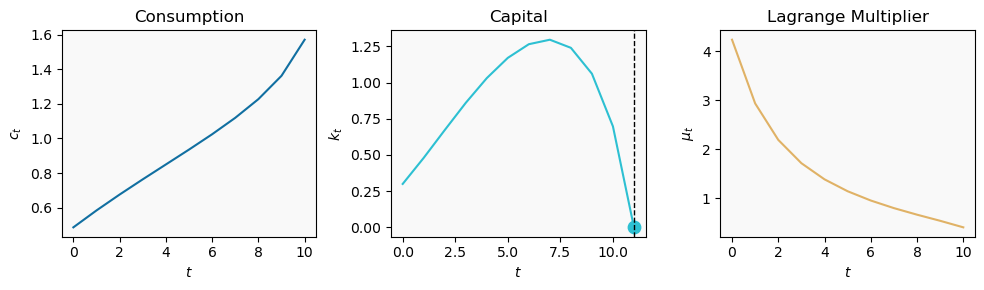

([array([0.48574024, 0.58356735, 0.6755383 , 0.76359572, 0.84964636,
         0.93576284, 1.02452871, 1.11969764, 1.2277586 , 1.36284366,
         1.57171478])],
 [array([3.00000000e-01, 4.80384709e-01, 6.72308675e-01, 8.60522291e-01,
         1.03135353e+00, 1.17131994e+00, 1.26569957e+00, 1.29671603e+00,
         1.24061310e+00, 1.06178439e+00, 6.97685821e-01, 6.69433900e-06])])

In [40]:
plot_paths(0.3, 0.3, [10])